,Date,Type,Value,Year,Skupina
0,2002-01-01,JELŠA,0.0,2002,Drevesa
1,2002-01-02,JELŠA,0.0,2002,Drevesa
2,2002-01-03,JELŠA,0.0,2002,Drevesa
3,2002-01-04,JELŠA,0.0,2002,Drevesa
4,2002-01-05,JELŠA,0.0,2002,Drevesa


Type
GABER            7028.0
KOPRIVOVKE       4264.0
PRAVI KOSTANJ    3529.0
JELŠA            2659.0
TRAVE            2652.0
CIPRESOVKE       2395.0
BREZA            2366.0
BOR              1910.0
LESKA            1498.0
JESEN            1491.0
BUKEV            1024.0
HRAST             550.0
PLATANA           477.0
PELIN             468.0
AMBROZIJA         447.0
TRPOTEC           347.0
KISLICA           199.0
OLJKA              98.0
Name: Value, dtype: float64

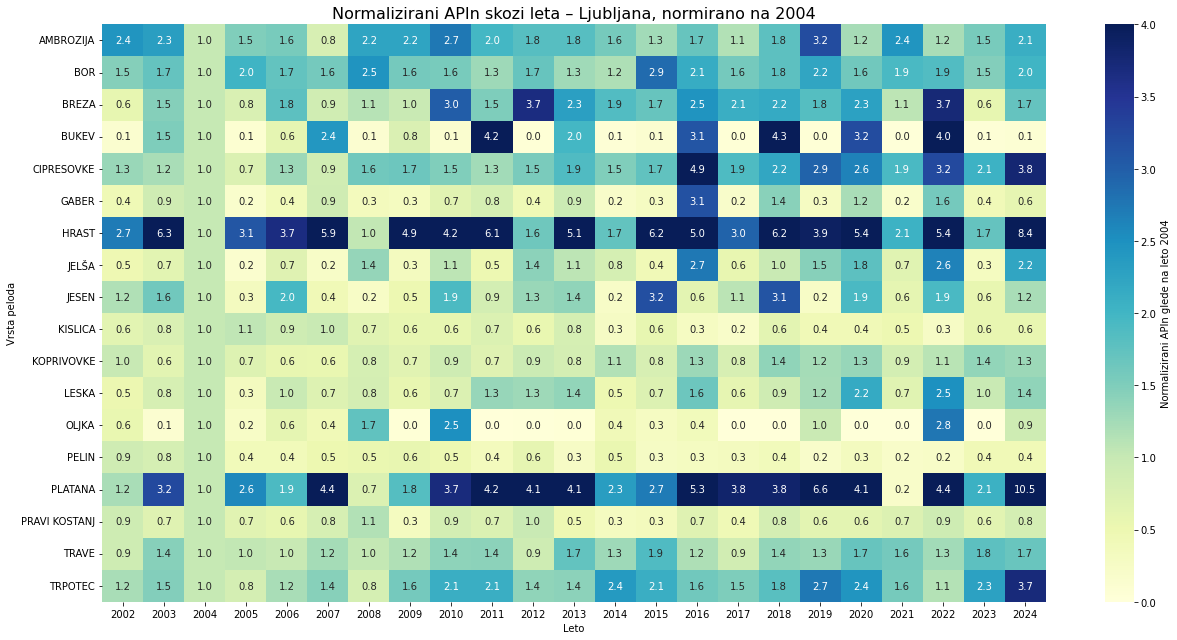

,Date,Type,Value,Year,Skupina
0,2002-01-01,JELŠA,0.0,2002,Drevesa
1,2002-01-02,JELŠA,0.0,2002,Drevesa
2,2002-01-03,JELŠA,0.0,2002,Drevesa
3,2002-01-04,JELŠA,0.0,2002,Drevesa
4,2002-01-05,JELŠA,0.0,2002,Drevesa


Type
KOPRIVOVKE       7511.0
JELŠA            5721.0
GABER            5147.0
PRAVI KOSTANJ    3298.0
BREZA            3239.0
TRAVE            2967.0
BOR              2787.0
CIPRESOVKE       1696.0
LESKA            1550.0
AMBROZIJA         959.0
JESEN             927.0
HRAST             888.0
BUKEV             879.0
PELIN             596.0
PLATANA           265.0
TRPOTEC           259.0
KISLICA           159.0
OLJKA              28.0
Name: Value, dtype: float64

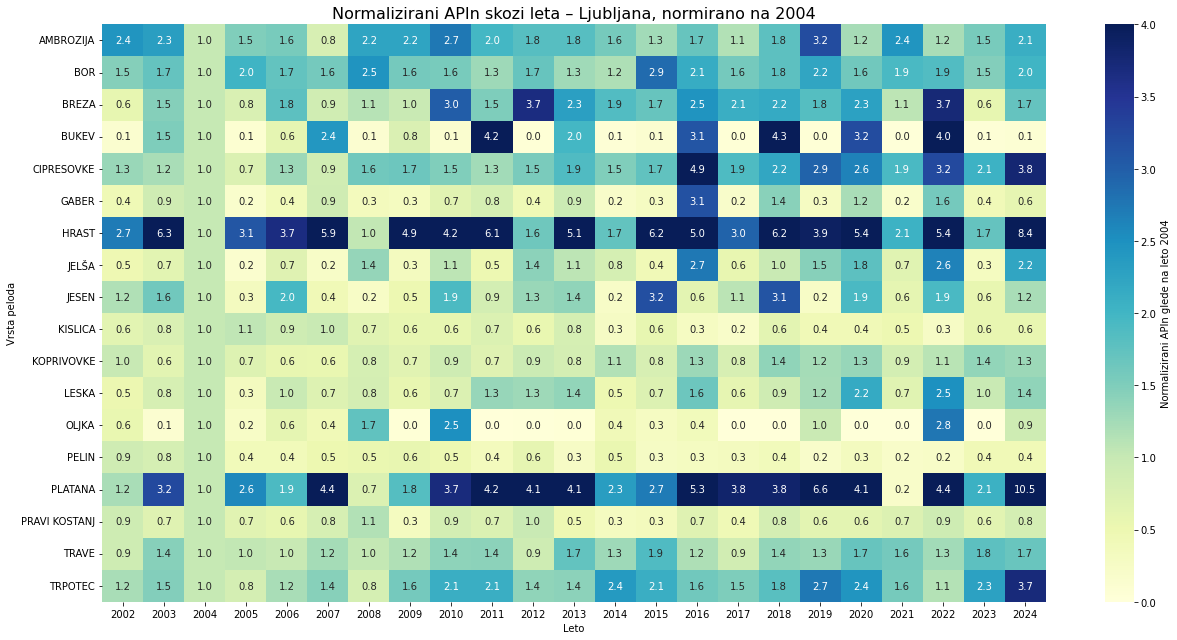

,Date,Type,Value,Year,Skupina
0,2002-01-01,JELŠA,0.0,2002,Drevesa
1,2002-01-02,JELŠA,0.0,2002,Drevesa
2,2002-01-03,JELŠA,0.0,2002,Drevesa
3,2002-01-04,JELŠA,0.0,2002,Drevesa
4,2002-01-05,JELŠA,0.0,2002,Drevesa


Type
CIPRESOVKE       7608.0
GABER            6777.0
KOPRIVOVKE       2215.0
TRAVE            1567.0
BOR              1496.0
OLJKA            1414.0
JESEN            1379.0
PRAVI KOSTANJ    1136.0
JELŠA             769.0
LESKA             625.0
HRAST             585.0
PLATANA           473.0
AMBROZIJA         414.0
BUKEV             286.0
TRPOTEC           214.0
BREZA             167.0
PELIN             131.0
KISLICA            73.0
Name: Value, dtype: float64

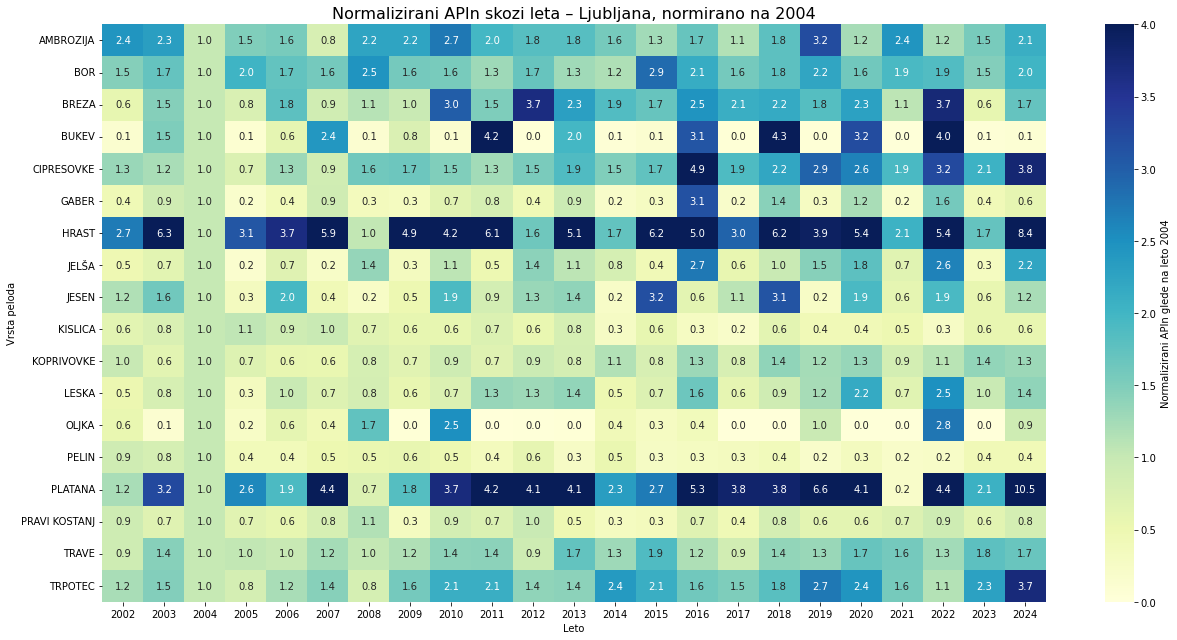

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


location = ["Ljubljana", "Maribor", "Primorje"]
for loc in location:
    path = os.path.join("data", "processed", f"{loc}_processed.csv")

    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    display(df.head())
    df_sum = df.groupby(['Type', 'Year'])['Value'].sum().reset_index()
    ref_year = 2004
    ref_sums = df_sum[df_sum['Year'] == ref_year].set_index('Type')['Value'].sort_values(ascending=False)
    display(ref_sums)
    def norm_to_ref(row):
        ref = ref_sums.get(row['Type'], np.nan)
        return row['Value'] / ref if pd.notnull(ref) and ref != 0 else np.nan

    df_sum['Normalized_APIn'] = df_sum.apply(norm_to_ref, axis=1)
    heatmap_df = df_sum.pivot(index='Type', columns='Year', values='Normalized_APIn')


    path = os.path.join("data", "processed", "Ljubljana_processed.csv")
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # 1. Calculate annual sums
    df_sum = df.groupby(['Type', 'Year'])['Value'].sum().reset_index()

    # 2. Reference year normalization
    ref_year = 2004
    ref_sums = df_sum[df_sum['Year'] == ref_year].set_index('Type')['Value']
    df_sum['Normalized_APIn'] = df_sum.apply(
        lambda row: row['Value'] / ref_sums.get(row['Type'], np.nan) if pd.notnull(ref_sums.get(row['Type'], np.nan)) and ref_sums.get(row['Type'], np.nan) != 0 else np.nan,
        axis=1
    )

    # 3. Pivot for heatmap
    heatmap_df = df_sum.pivot(index='Type', columns='Year', values='Normalized_APIn')

    # 4. Plot
    plt.figure(figsize=(18, 9))
    ax = sns.heatmap(
        heatmap_df, 
        annot=True, 
        fmt=".1f", 
        cmap="YlGnBu",
        vmax = 4,
        vmin = 0,
        cbar_kws={"label": f"Normalizirani APIn glede na leto {ref_year}"}
    )
    plt.title(f"Normalizirani APIn skozi leta – Ljubljana, normirano na {ref_year}", fontsize=16)
    plt.xlabel("Leto")
    plt.ylabel("Vrsta peloda")
    plt.tight_layout()
    plt.savefig(os.path.join("results", f"{loc}_heatmap_norm_{ref_year}.png"), dpi=300)
    plt.show()

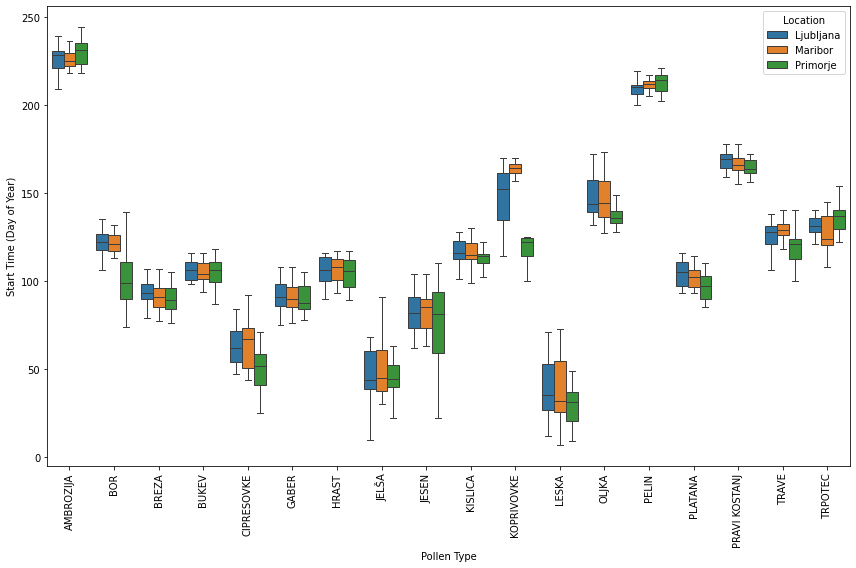

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
4,BOR,Ljubljana vs Primorje,0.000023,0.001253,True
5,BOR,Maribor vs Primorje,0.000009,0.000478,True
30,KOPRIVOVKE,Ljubljana vs Maribor,0.000470,0.025389,True
32,KOPRIVOVKE,Maribor vs Primorje,0.000015,0.000834,True
50,TRAVE,Maribor vs Primorje,0.000509,0.027488,True


-------------------- Mann-Whitney U Test Results --------------------


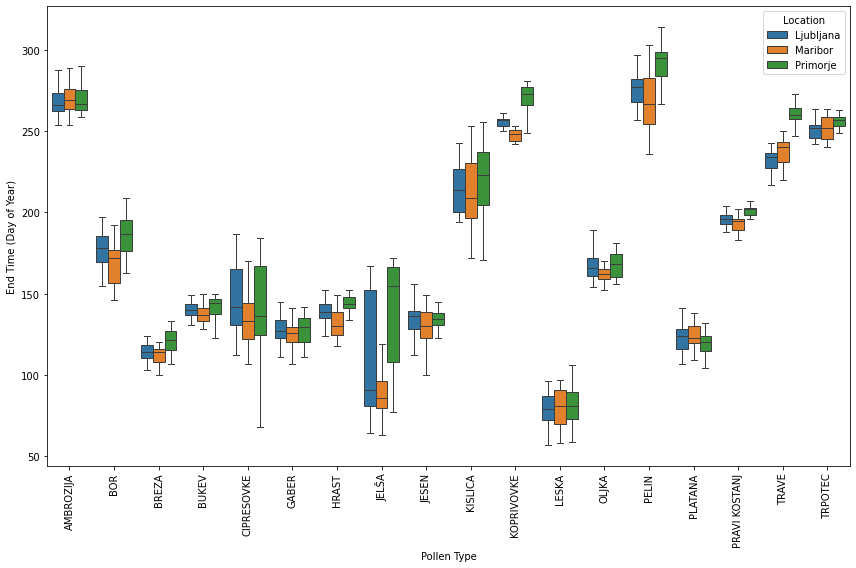

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
5,BOR,Maribor vs Primorje,7.581438e-05,4.093976e-03,True
30,KOPRIVOVKE,Ljubljana vs Maribor,2.660999e-06,1.436939e-04,True
31,KOPRIVOVKE,Ljubljana vs Primorje,8.130386e-07,4.390408e-05,True
32,KOPRIVOVKE,Maribor vs Primorje,1.899315e-08,1.025630e-06,True
40,PELIN,Ljubljana vs Primorje,9.945951e-05,5.370813e-03,True
41,PELIN,Maribor vs Primorje,6.899171e-05,3.725553e-03,True
49,TRAVE,Ljubljana vs Primorje,6.462007e-09,3.489484e-07,True
50,TRAVE,Maribor vs Primorje,9.648937e-09,5.210426e-07,True


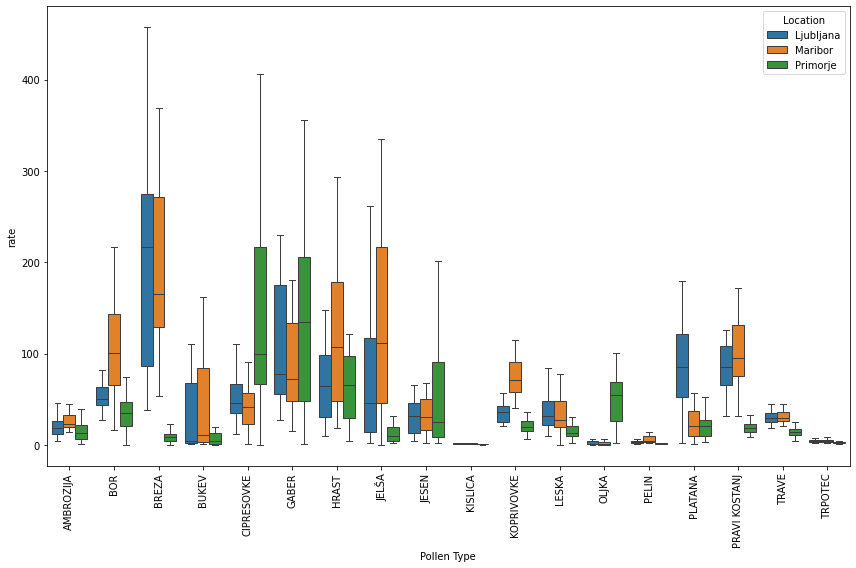

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
3,BOR,Ljubljana vs Maribor,2.436410e-04,1.315661e-02,True
5,BOR,Maribor vs Primorje,5.425589e-06,2.929818e-04,True
13,CIPRESOVKE,Ljubljana vs Primorje,9.087691e-04,4.907353e-02,True
14,CIPRESOVKE,Maribor vs Primorje,2.234682e-05,1.206728e-03,True
28,KISLICA,Ljubljana vs Primorje,5.292286e-05,2.857834e-03,True
29,KISLICA,Maribor vs Primorje,1.113678e-05,6.013861e-04,True
30,KOPRIVOVKE,Ljubljana vs Maribor,1.922329e-07,1.038057e-05,True
31,KOPRIVOVKE,Ljubljana vs Primorje,1.576498e-04,8.513090e-03,True
32,KOPRIVOVKE,Maribor vs Primorje,1.864666e-08,1.006919e-06,True
40,PELIN,Ljubljana vs Primorje,1.878938e-04,1.014626e-02,True


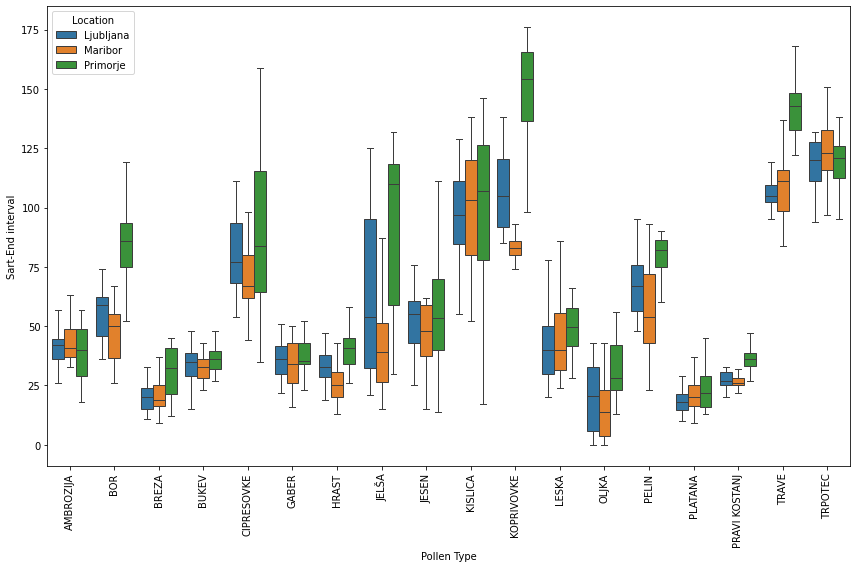

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
4,BOR,Ljubljana vs Primorje,3.348410e-06,0.000181,True
5,BOR,Maribor vs Primorje,1.242192e-07,0.000007,True
30,KOPRIVOVKE,Ljubljana vs Maribor,1.165519e-07,0.000006,True
31,KOPRIVOVKE,Ljubljana vs Primorje,1.492461e-05,0.000806,True
32,KOPRIVOVKE,Maribor vs Primorje,1.177058e-07,0.000006,True
41,PELIN,Maribor vs Primorje,2.133960e-04,0.011523,True
49,TRAVE,Ljubljana vs Primorje,1.886051e-07,0.000010,True
50,TRAVE,Maribor vs Primorje,3.220890e-07,0.000017,True


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns

# Load JSON data from the files containing detailed yearly results (the *_results_2.json files)
files = {
    "Ljubljana": os.path.join("results","Ljubljana_results_2.json"),
    "Maribor": os.path.join("results","Maribor_results_2.json"),
    "Primorje": os.path.join("results","Primorje_results_2.json")
}

data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", "Start", "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)

# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Type", y="Start", hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel("Start Time (Day of Year)")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


from scipy.stats import mannwhitneyu
import itertools
import statsmodels.stats.multitest as smm


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", "Start", "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1]["Start"].values
        group2 = data_subset[data_subset["Location"] == loc2]["Start"].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}:")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
significant_results.head(20)
display(significant_results.head(20))
print(f"{20*'-'} Mann-Whitney U Test Results {20*'-'}")
### ---------------------------------------------------- ###

var = "End"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Type", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel("End Time (Day of Year)")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))


### ---------------------------------------------------- ###

var = "rate"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Type", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel(f"{var}")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))

### ---------------------------------------------------- ###

var = "Sart-End interval"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Type", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Type", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel(f"{var}")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Type", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Type"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Type"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))

In [14]:
import pandas as pd
import json

# Load summary files with CP (APIn) values
files_summary = {
    "Ljubljana": os.path.join("results","Ljubljana_results.json"),
    "Maribor": os.path.join("results","Maribor_results.json"),
    "Primorje": os.path.join("results","Primorje_results.json")
}
apin_data = []

# Extract CP info for each pollen type and location
for location, filepath in files_summary.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    for pollen, values in content.items():
        if "CP" in values:
            apin_data.append({
                "Location": location,
                "Pollen": pollen,
                "Trend": values["CP"].get("Trend", None),
                "Intercept": values["CP"].get("Intercept", None),
                "R2": values["CP"].get("R2", None),
                "min_CP": values["CP"].get("min(CP)", None),
                "avg_CP": values["CP"].get("avg(CP)", None),
                "max_CP": values["CP"].get("max(CP)", None)
            })
print(f"{20*'-'} APIn Summary Data {20*'-'}")
apin_df = pd.DataFrame(apin_data)

# Show the first rows to inspect
display(apin_df.head())
apin_df.to_excel("apin_summary.xlsx", index=False)

-------------------- APIn Summary Data --------------------


,Location,Pollen,Trend,Intercept,R2,min_CP,avg_CP,max_CP
0,Ljubljana,AMBROZIJA,-0.655138,2128.576087,0.000277,355.0,809.782609,1435.0
1,Ljubljana,BOR,27.814229,-52663.913043,0.054231,1910.0,3326.130435,5490.0
2,Ljubljana,BREZA,109.291502,-215831.402174,0.125621,1378.0,4172.391304,8847.0
3,Ljubljana,BUKEV,34.444664,-68087.978261,0.021982,20.0,1249.130435,4443.0
4,Ljubljana,CIPRESOVKE,240.799407,-480073.858696,0.479459,1794.0,4655.347826,11702.0
